In [1]:
import torch
import pyredner
import h5py
import urllib
import time
import numpy as np

from matplotlib.pyplot import imshow
%matplotlib inline
import os
os.environ['QT_QPA_PLATFORM']='offscreen'
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib import animation

from IPython.display import HTML

In [2]:
with h5py.File(r'./model2017-1_bfm_nomouth.h5', 'r') as hf:
    shape_mean = torch.tensor(np.array(hf['shape/model/mean']), device = pyredner.get_device())
    shape_basis = torch.tensor(np.array(hf['shape/model/pcaBasis']), device = pyredner.get_device())
    triangle_list = torch.tensor(np.array(hf['shape/representer/cells']), device = pyredner.get_device())
    color_mean = torch.tensor(np.array(hf['color/model/mean']), device = pyredner.get_device())
    color_basis = torch.tensor(np.array(hf['color/model/pcaBasis']), device = pyredner.get_device())

In [8]:
indices = triangle_list.permute(1, 0).contiguous()

def model(
        cam_pos, 
        cam_look_at, 
        shape_coeffs, 
        color_coeffs, 
        ambient_color, 
        dir_light_intensity):
    vertices = (shape_mean + shape_basis @ shape_coeffs).view(-1, 3)
    normals = pyredner.compute_vertex_normal(vertices, indices)
    colors = (color_mean + color_basis @ color_coeffs).view(-1, 3)
    m = pyredner.Material(use_vertex_color = True)
    obj = pyredner.Object(vertices = vertices, 
                          indices = indices, 
                          normals = normals, 
                          material = m, 
                          colors = colors)
    cam = pyredner.Camera(position = cam_pos,
                          # Center of the vertices                          
                          look_at = cam_look_at,
                          up = torch.tensor([0.0, 1.0, 0.0], device = pyredner.get_device()),
                          fov = torch.tensor([45.0], device = pyredner.get_device()),
                          resolution = (256, 256))
    scene = pyredner.Scene(camera = cam, objects = [obj])
    ambient_light = pyredner.AmbientLight(ambient_color)
    dir_light = pyredner.DirectionalLight(torch.tensor([0.0, 0.0, -1.0], device = pyredner.get_device()), 
                                          dir_light_intensity)
    img = pyredner.render_deferred(scene = scene, 
                                   lights = [ambient_light, dir_light])
    return img

Scene construction, time: 0.00456 s
Forward pass, time: 0.01249 s


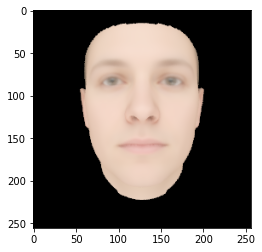

In [9]:
cam_pos = torch.tensor([-0.2697, -5.7891, 373.9277], device = pyredner.get_device())
cam_look_at = torch.tensor([-0.2697, -5.7891, 54.7918], device = pyredner.get_device())
img = model(cam_pos, 
            cam_look_at, 
            torch.zeros(199, device = pyredner.get_device()),
            torch.zeros(199, device = pyredner.get_device()),
            torch.ones(3, device = pyredner.get_device()), 
            torch.zeros(3, device = pyredner.get_device()))

imshow(torch.pow(img, 1.0/2.2).cpu())

True

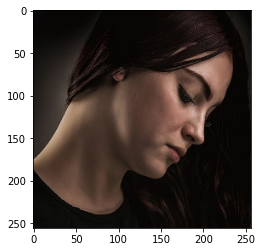

In [50]:
import cv2 as cv
img = cv.cvtColor(cv.imread("./my_photo.jpg"),cv.COLOR_BGR2RGB)
img = img[100:700, 100:700]
img = cv.resize(img, (256,256))
imshow(img)
cv.imwrite("target.png", img)

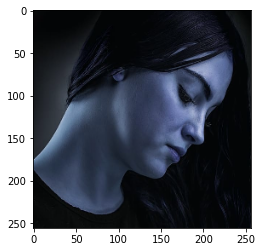

In [51]:
target = pyredner.imread('target.png').to(pyredner.get_device())

imshow(torch.pow(target, 1.0/2.2).cpu())

In [52]:
cam_pos = torch.tensor([-0.2697, -5.7891, 373.9277], 
                       requires_grad=True)
cam_look_at = torch.tensor([-0.2697, -5.7891, 54.7918], 
                           requires_grad=True)
shape_coeffs = torch.zeros(199, device = pyredner.get_device(), 
                           requires_grad=True)
color_coeffs = torch.zeros(199, device = pyredner.get_device(), 
                           requires_grad=True)
ambient_color = torch.ones(3, device = pyredner.get_device(), 
                           requires_grad=True)
dir_light_intensity = torch.zeros(3, device = pyredner.get_device(), 
                                  requires_grad=True)

# Use two different optimizers for different learning rates
optimizer = torch.optim.Adam(
                             [
                              shape_coeffs, 
                              color_coeffs, 
                              ambient_color, 
                              dir_light_intensity], 
                             lr=0.1)
cam_optimizer = torch.optim.Adam([cam_pos, cam_look_at], lr=0.5)

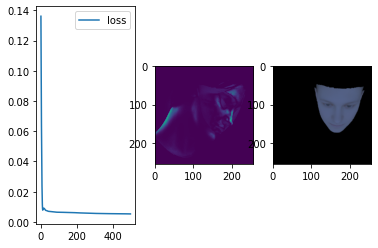

In [53]:
plt.figure()
imgs, losses = [], []

# Run 500 Adam iterations
num_iters = 500
for t in range(num_iters):
    optimizer.zero_grad()
    cam_optimizer.zero_grad()
    img = model(cam_pos, cam_look_at, shape_coeffs, 
                color_coeffs, ambient_color, dir_light_intensity)
    # Compute the loss function. Here it is L2 plus a regularization 
    # term to avoid coefficients to be too far from zero.
    # Both img and target are in linear color space, 
    # so no gamma correction is needed.

    loss = (img - target).pow(2).mean()
    loss = loss + 0.0001 * shape_coeffs.pow(2).mean() + 0.001 * color_coeffs.pow(2).mean()
    loss.backward()

    optimizer.step()
    cam_optimizer.step()

    ambient_color.data.clamp_(0.0)
    dir_light_intensity.data.clamp_(0.0)

    # Plot the loss
    f, (ax_loss, ax_diff_img, ax_img) = plt.subplots(1, 3)
    losses.append(loss.data.item())

    # Only store images every 10th iterations
    if t % 10 == 0:
        # Record the Gamma corrected image
        imgs.append(torch.pow(img.data, 1.0/2.2).cpu()) 
    clear_output(wait=True)
    ax_loss.plot(range(len(losses)), losses, label='loss')
    ax_loss.legend()
    ax_diff_img.imshow((img -target).pow(2).sum(dim=2).data.cpu())
    ax_img.imshow(torch.pow(img.data.cpu(), 1.0/2.2))
    plt.show()

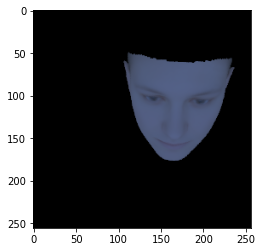

In [54]:
fig = plt.figure()

# Clamp to avoid complains
im = plt.imshow(imgs[0].clamp(0.0, 1.0), animated=True)

def update_fig(i):
    im.set_array(imgs[i].clamp(0.0, 1.0))
    return im,
anim = animation.FuncAnimation(fig, update_fig, 
                               frames=len(imgs), interval=50, blit=True)
HTML(anim.to_jshtml())

In [57]:
writer = animation.PillowWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
anim.save('./scatter.gif', writer=writer)